# Binary Classification Practice


# Predict Points Above or Below a Quadratic Equation

Create a model that can predict if a random dot is above or below the graph `f(x) = x^2`. Use the following data to train and test your model.

torch.manual_seed(17)
<br>
train_coord = torch.rand(200, 2)

torch.manual_seed(28)
<br>
test_coord = torch.rand(200, 2)

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import ray
from ray import train
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import os
import tempfile
import helper_functions as hf


In [176]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(17)
x_train = torch.rand(200, 1, 
                         requires_grad=True,
                         device=device) * 10

torch.manual_seed(18)
y_train = torch.rand(200, 1, 
                         requires_grad=True,
                         device=device) * 100

train_coord = torch.hstack([x_train, y_train])
print(train_coord.requires_grad)

torch.manual_seed(28)
test_coord = torch.rand(200, 2, 
                        requires_grad=True, 
                        device=device)

Using device: cpu
True


Utilizes Ray Tune to find random hyperparameters that returns the lowest loss

In [143]:
class Model_0(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x
    


# create a ray tune function to run tune.rune()
def tune_model() -> nn.Module:
    # output_dir = "C:/Users/chino/Git/python_coding/Notebooks/ray_results"

    searchspace = {
        "lr"        : tune.uniform(1e-3, 1),
        "loop_count": tune.randint(10, 10000),
        "hidden_size": tune.randint(10, 200),
    }

    # shutdown any clusters that are still active then run ray tune
    ray.shutdown() 
    analysis = tune.run(
        train_model,    # cannot take arguements
        config               = searchspace,
        num_samples          = 20,
        metric               = "loss",
        mode                 = "min",
        # storage_path         = output_dir,
    )
    
    best_trial = analysis.best_config
    best_trial_checkpoint_loc = analysis.best_checkpoint.to_directory()
    checkpoint_dict = torch.load(os.path.join(best_trial_checkpoint_loc, "checkpoint.pt"), weights_only=True)
    
    print("Best hyperparameters found: ", best_trial)
    # print("Model parameters: ", checkpoint_dict["model_state"])

    model = Model_0(input_size=2, hidden_size=best_trial["hidden_size"])
    model.load_state_dict(checkpoint_dict["model_state"])
    
    torch.save(model.state_dict(), "state_dict/binary_model_0_state_dict.pt")
    return model


def train_model(config):
    model = Model_0(train_coord.shape[-1], hidden_size=config["hidden_size"])
    data = train_coord
    label = generate_labels(data)

    loop = config["loop_count"]
    lr = config["lr"]

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    
    model.train()

    for epoch in range(loop):
        optimizer.zero_grad()
        output  = model(data).squeeze()
        loss    = criterion(output, label)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            with tempfile.TemporaryDirectory() as tempdir:
                torch.save(
                    {"epoch": epoch, "model_state": model.state_dict()},
                    os.path.join(tempdir, "checkpoint.pt"),
                )
                train.report(
                    metrics     = {"loss": loss.item()},
                    checkpoint  = train.Checkpoint.from_directory(tempdir)
                )

        # if (epoch+1) % (loop/5) == 0:
        #     print(f"Ran {epoch+1} loops; loss: {loss.item()}")

def test_model(model: nn.Module, data: torch.Tensor, label: torch.Tensor):
    model.eval()
    with torch.inference_mode():
        output = model(data).squeeze()
        
        accuracy = (output.round() == label).float().mean()
        print("Accuracy {:.2f}".format(accuracy * 100))
            

def f(x):
    return torch.pow(x, 2)


def generate_labels(input):
    x = input[:, 0]
    y = input[:, 1]
    return (y > f(x)) * 1.


In [144]:
# print(generate_labels(train_coord))
# model = Model_0(train_coord.shape[-1], hidden_size=100) # include parameters
# train_model(model, train_coord, generate_labels(train_coord), 10000)
# test_model(model, test_coord, generate_labels(test_coord))

model = tune_model()

2025-02-26 13:21:22,350	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-26 13:21:24,401	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-02-26 13:21:24,404	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss,should_checkpoint
train_model_a1cf0_00000,29,True
train_model_a1cf0_00001,29,True
train_model_a1cf0_00002,29,True
train_model_a1cf0_00003,29,True
train_model_a1cf0_00004,70.5063,True
train_model_a1cf0_00005,29,True
train_model_a1cf0_00006,29,True
train_model_a1cf0_00007,29,True
train_model_a1cf0_00008,29,True
train_model_a1cf0_00009,0.274035,True


(train_model pid=23760) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/chino/ray_results/train_model_2025-02-26_13-21-24/train_model_a1cf0_00004_4_hidden_size=158,loop_count=1109,lr=0.7951_2025-02-26_13-21-24/checkpoint_000000)
(train_model pid=984) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/chino/ray_results/train_model_2025-02-26_13-21-24/train_model_a1cf0_00003_3_hidden_size=116,loop_count=7803,lr=0.6555_2025-02-26_13-21-24/checkpoint_000048) [repeated 430x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_model pid=984) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/chino/ray_results/train_model_2025-02-26_13-21-24/train_model_a1cf0_00003_3_hidden_size=116,loop_count=7803,lr=0.6555_2025-02-26_13-21-24

Best hyperparameters found:  {'lr': 0.06634910766358428, 'loop_count': 6955, 'hidden_size': 57}


Accuracy 97.00


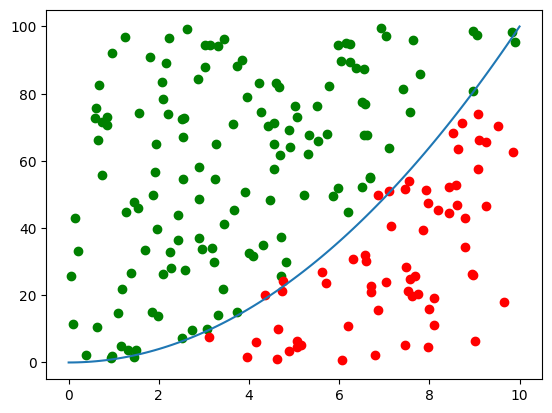

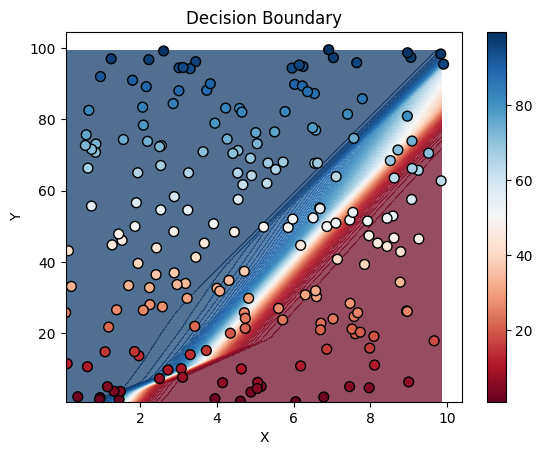

In [145]:
torch.manual_seed(27)
x_test = torch.rand(200, 1, 
                        requires_grad=True,
                        device=device) * 10

torch.manual_seed(28)
y_test = torch.rand(200, 1, 
                        requires_grad=True,
                        device=device) * 100

test_coord = torch.hstack([x_test, y_test])

x_plot = np.array(test_coord[:, 0].detach())
y_plot = np.array(test_coord[:, 1].detach())

x_graph = torch.arange(0, 10.1, 0.1)
y_graph = torch.arange(0, 10.1, 0.1)

model.eval()
with torch.inference_mode():
    output = np.array(model(test_coord).squeeze())
condition = output > 0.5

test_model(model, test_coord, generate_labels(test_coord))
plt.scatter(x_plot[condition], y_plot[condition], c='g', label='Above')
plt.scatter(x_plot[~condition], y_plot[~condition], c='r', label='Below')

plt.plot(x_graph, f(x_graph))
plt.show()

hf.plot_decision_boundaries(model, torch.from_numpy(x_plot), torch.from_numpy(y_plot))


In [38]:
# save the model's state dict aka its weights and biases

MODEL_PATH = Path("state dictionary")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Predict_Points_Above_or_Below_a_Quadratic_Equation_State_Dict.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model.state_dict(), MODEL_SAVE_PATH)


In [7]:
# create a new model 
model_1 = Model_0(train_coord.shape[-1], hidden_size=100)

# load the original model's state_dict()
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

NameError: name 'MODEL_SAVE_PATH' is not defined

In [40]:
model_1.eval()
with torch.inference_mode():
    model_1_pred = np.array(model_1(test_coord).squeeze())

test_model(model_1, test_coord, generate_labels(test_coord))


Accuracy 99.00


# Quadratic Model Redo
Observe how the decision boundaries change when we use different layer and activation functions

In [551]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(17)
x_train = torch.rand(200, 1, 
                         requires_grad=False,
                         device=device) * 10

torch.manual_seed(18)
y_train = torch.rand(200, 1, 
                         requires_grad=False, # setting this to True will break the code, says loss.backwards() can't run a second time or access data lost
                         device=device) * 100

train_coord = torch.hstack([x_train, y_train]).requires_grad_(True)
test = torch.rand(200, 2, 
                         requires_grad=True,
                         device=device)

torch.manual_seed(27)
x_test = torch.rand(200, 1, 
                         requires_grad=True,
                         device=device) * 10

torch.manual_seed(28)
y_test = torch.rand(200, 1, 
                         requires_grad=True,
                         device=device) * 100

test_coord = torch.hstack([x_test, y_test]).requires_grad_(True)

Using device: cpu


In [629]:
import torch.nn.functional as F

HIDDEN_UNITS = 100

class model_redo(nn.Module):
    def __init__(self, input):
        super().__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(input, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS),
            nn.CELU(),
            nn.Linear(HIDDEN_UNITS, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequence(x)


def train_model(model: nn.Module, data: torch.Tensor, label, loop):
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

    model.train()
    for epoch in range(loop):
        optimizer.zero_grad()
        output = model(data).squeeze()        
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        if (epoch+1) % (loop/5) == 0:
            print(f"Ran {epoch+1} loops; loss: {loss.item()}")

def test_model(model: nn.Module, data, label):
    model.eval()
    with torch.inference_mode():
        output = model(data).squeeze()

        accuracy = (output.round() == label).float().mean()
        print("Accuracy {:.2f}".format(accuracy * 100))
        

In [630]:
model = model_redo(train_coord.shape[-1])
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

# train_coord = test
train_model(model, train_coord,generate_labels(train_coord), 10000)
test_model(model, test_coord, generate_labels(test_coord))
# print(model(train_coord))


Ran 2000 loops; loss: 0.06943970918655396
Ran 4000 loops; loss: 0.042534828186035156
Ran 6000 loops; loss: 0.03398561105132103
Ran 8000 loops; loss: 0.04222087562084198
Ran 10000 loops; loss: 0.01828606054186821
Accuracy 98.50


Accuracy 98.00


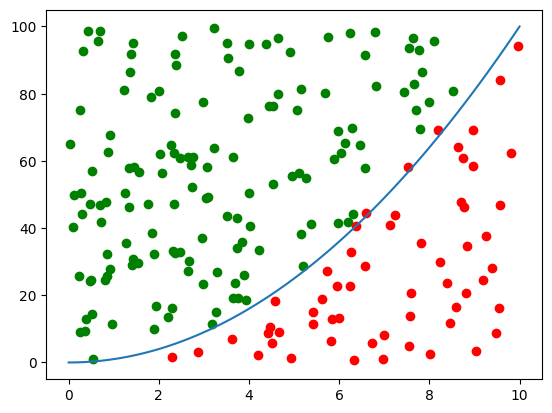

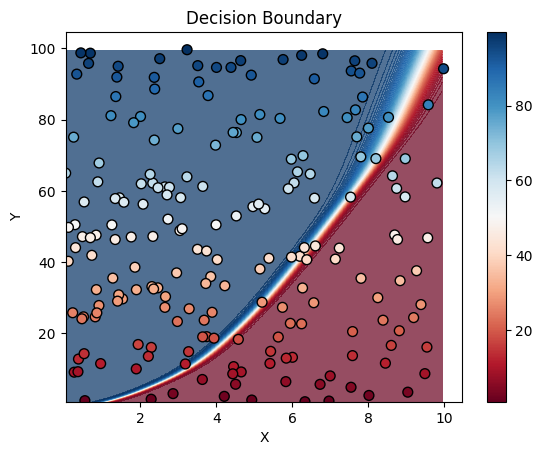

In [640]:
# torch.manual_seed(27)
x_test = torch.rand(200, 1, 
                        requires_grad=True,
                        device=device) * 10

# torch.manual_seed(28)
y_test = torch.rand(200, 1, 
                        requires_grad=True,
                        device=device) * 100

test_coord = torch.hstack([x_test, y_test])

x_plot = np.array(test_coord[:, 0].detach())
y_plot = np.array(test_coord[:, 1].detach())

x_graph = torch.arange(0, 10.1, 0.1)
y_graph = torch.arange(0, 10.1, 0.1)

model.eval()
with torch.inference_mode():
    output = np.array(model(test_coord).squeeze())
condition = output > 0.5

test_model(model, test_coord, generate_labels(test_coord))
plt.scatter(x_plot[condition], y_plot[condition], c='g', label='Above')
plt.scatter(x_plot[~condition], y_plot[~condition], c='r', label='Below')

plt.plot(x_graph, f(x_graph))
plt.show()

hf.plot_decision_boundaries(model, torch.from_numpy(x_plot), torch.from_numpy(y_plot))

# Predict if the image has a dog 

image tensors follow the format shape = [batch_size, color_channel, width, height]. 
- batch_size refers to how many images to look at